In [36]:
using Random, Distributions
using LinearAlgebra
using Gurobi, JuMP
using Plots

┌ Info: Recompiling stale cache file /home/skand/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190


In [2]:
# Create a gurobi model without the annoying academic license message
gurobi_env = Gurobi.Env()
function create_gurobi_model(; TimeLimit=-1, LogFile="logs.txt")
    model = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env)));
    if TimeLimit >= 0
        println("Set Gurobi TimeLimit.")
        set_optimizer_attribute(model, "TimeLimit", TimeLimit)
    end
    set_optimizer_attribute(model, "LogFile", LogFile)
    set_optimizer_attribute(model, "OutputFlag", 0)
    return model
end;

Academic license - for non-commercial use only


In [108]:
Random.seed!(2022)

# Params
α = 0.01
γ = 0.0011
n, p = 100, 1
t_α = quantile(TDist(n-p), 1 - α/2) # Beware: n-p-1 if we add intercept
#t_α = 1
# Data
X = rand(n, p)
y = rand(n)

# Variance
M = X'X
M_inv = M^-1
σ_tilde =  sqrt((y'*(I - X*M_inv*X')*y)/(n-p))
σ_X = σ_tilde * sqrt.(diag(M_inv))

;

In [109]:
function get_max_inner(s)

    # Compute matrices
    Z = Diagonal(s)    
    # Compute D
    D = (I/γ + Z*Z*M)^-1

    # Compute norm
    function compute_DZ_square_norm(in_norm)
        return in_norm' * D*Z*Z * in_norm
    end
    
    # Compute max
    model = create_gurobi_model()

    @variable(model, λ[1:p] >= 0)

    obj_1 = 0.5*y'y
    obj_2 = t_α*λ'*((Z*Z)*σ_X)
    obj_3 = - 0.5 * compute_DZ_square_norm(X'y + Z*λ)
#     obj_3 = -0.5*(y'X*D*Z*Z*X'*y + y'*X*D*Z*λ + λ'*Z*D*Z*λ)

    @objective(model, Max, obj_1 + obj_2 + obj_3)

    optimize!(model)
    if termination_status(model) == MOI.OPTIMAL
        return objective_value(model)
    end
    return Inf
end

get_max_inner (generic function with 1 method)

In [110]:
nbr_val = 1000
obj_val = []
list_s = [[2*i/nbr_val-1] for i in 1:nbr_val]
for s in list_s
    append!(obj_val,[get_max_inner(s)])
end

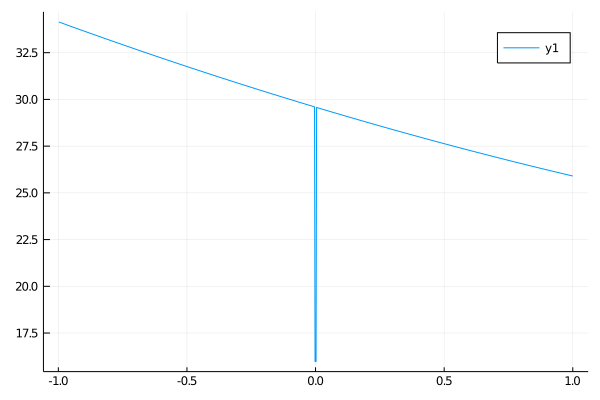

In [111]:
plot([(list_s...)...],obj_val)